<a href="https://colab.research.google.com/github/mulholio/flower-classifier/blob/master/Flower_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Classifier

Classifying https://www.robots.ox.ac.uk/~vgg/data/flowers/ using deep learning.

In [1]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 194kB 8.1MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 


In [2]:
import csv
import re
from google.colab import drive
from fastai.vision.all import *

## Data

Data for this model comes from [Oxford's 102 Category Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

First, we download the images and labels from the above link directly to Drive.

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Download flower images to Drive
# !wget -c -P '/content/drive/My Drive/Colab Notebooks/data/' https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

dest = Path('/content/drive/My Drive/Colab Notebooks/data/')
path = untar_data('https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz', dest=dest, force_download=False)

As the labels were in `.mat` format, I had to do some manual wrangling with Octave and vim to get them into a more usable `flower_labels.csv` file.

We can go ahead and check that the csv file is in the format and location we expect.

In [40]:
labels = []
with open(Path('/content/drive/My Drive/Colab Notebooks/data/flower_labels.csv')) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    labels = next(reader)
    print(len(labels))
    print(labels[1000:1400]) # random slice from labels

8189
['46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '46', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74', '74'

In [9]:
# Check which label is which by comparing to count here: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html (probably checking the photo too)
len(list(filter(lambda x: x == '51', labels)))

258

### Making the DataBlock

In [10]:
file_index_regex = re.compile(r"image_(\d{5})\.jpg$")
def get_label(file_path):
  i = int(re.search(file_index_regex, str(file_path)).group(1)) - 1
  return int(labels[i])

get_label(Path('/content/drive/My Drive/Colab Notebooks/data/102flowers/image_06733.jpg'))

79

In [11]:
db = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                get_items=get_image_files, 
                splitter=RandomSplitter(),
                get_y=get_label,
                item_tfms = Resize(224),
                batch_tfms=aug_transforms(size=225, min_scale=0.75))
dls = db.dataloaders(path)

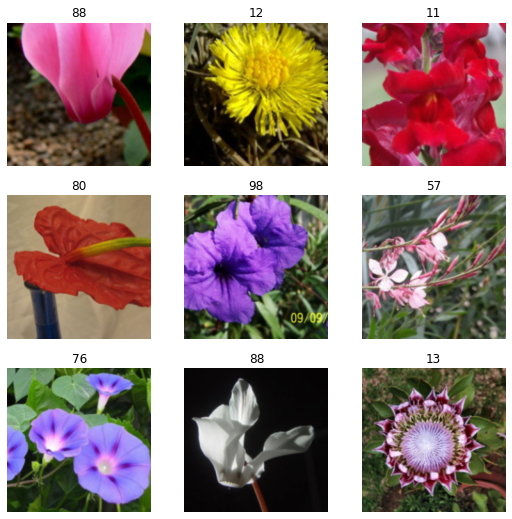

In [12]:
dls.show_batch()

### Making the Learner

We make a simple learner to train a baseline model.

In [35]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.015848932787775993)

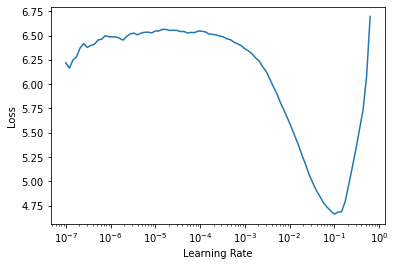

In [17]:
learn.lr_find()

In [36]:
# Start by doing default transfer learning with resnet, using learning rate picked from above
learn.fine_tune(2, base_lr=2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.992513,0.827407,0.219914,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.739252,0.234622,0.069640,01:16
1,0.334825,0.169556,0.048259,01:16


We get a 0.048 Error Rate after 2 epochs of `fine_tune` with our CNN. Not bad, but let's do better.

In [37]:
interpretation = ClassificationInterpretation.from_learner(learn)

In [38]:
interpretation.most_confused(min_val=2)

[(30, 31, 3), (32, 22, 2), (65, 64, 2), (88, 87, 2), (96, 97, 2), (97, 51, 2)]

## Improving the initial model



### Descriminative Learning Rates

In [20]:
# Make a new learner
learn2 = cnn_learner(dls, resnet34, metrics=error_rate)

The model here initially has all the pre-trained resnet layers frozen.

We start by running 3 epochs on just our new last layers for flower outputs.

In [21]:
learn2.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.370006,0.971321,0.241906,05:09
1,1.240760,0.424902,0.111790,01:13
2,0.752373,0.371003,0.098962,01:14


Now, we can unfreeze, and retrain the entire model with discriminative learning rates.

In [27]:
learn2.unfreeze()

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=7.585775847473997e-07)

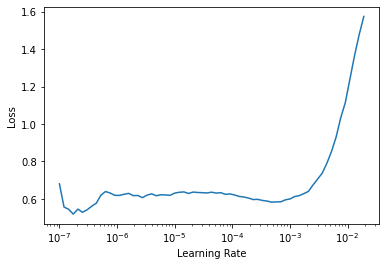

In [30]:
learn2.lr_find()

In [31]:
# We'll run lots of epochs initially to see where we start getting diminishing returns
# 
# We use a slice for lr_max to gradually increase the LR over the course of the training
# so that the earlier layers from ResNet do not get changed too much
learn2.fit_one_cycle(n_epoch=12, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.602306,0.338595,0.087966,01:19
1,0.538675,0.260968,0.071472,01:20
2,0.402011,0.202180,0.048259,01:20
3,0.305574,0.162083,0.043372,01:19
4,0.213067,0.139495,0.037874,01:19
5,0.159190,0.123703,0.037874,01:20
6,0.132330,0.101972,0.028711,01:19
7,0.104164,0.094852,0.025657,01:19
8,0.096225,0.090177,0.025046,01:19
9,0.086355,0.087562,0.027489,01:18


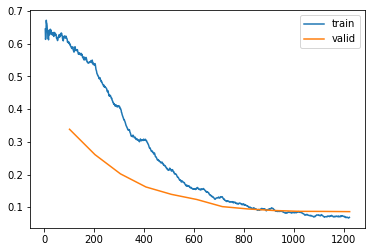

In [33]:
learn2.recorder.plot_loss()

In [34]:
# Run again to avoid early stopping
learn3 = cnn_learner(dls, resnet34, metrics=error_rate)
learn3.fit_one_cycle(n_epoch=3, lr_max=1e-3)
learn3.unfreeze()
learn3.fit_one_cycle(n_epoch=9, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,3.234745,0.930610,0.229078,01:13
1,1.218663,0.401595,0.104459,01:12
2,0.712430,0.354344,0.089188,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.574360,0.309475,0.078803,01:16
1,0.496178,0.224104,0.059866,01:16
2,0.378081,0.178624,0.048870,01:15
3,0.264825,0.137808,0.032987,01:16
4,0.182694,0.117272,0.028100,01:21
5,0.146567,0.105361,0.027489,01:18
6,0.123963,0.100078,0.026878,01:16
7,0.115071,0.097926,0.027489,01:17
8,0.107168,0.095593,0.026268,01:17


Marginally better! Quite happy with a 97.3% accuracy rate